In [109]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split

df = pd.read_csv("TennisLearningData.csv")
features = ["Weather","Temperature"]
X = df[features].copy()
y = df["Play"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.42312, random_state=42
)

# Index of feature columns
weather_index = "Weather"
temperature_index = "Temperature"


# Entropy

The formula for entropy is


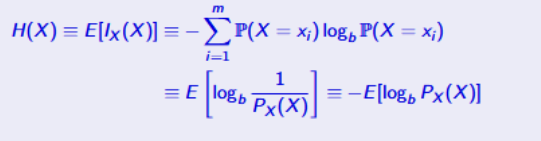

In [110]:
def calc_entropy(X):
    count = np.array(list(Counter(X).values()))
    p = count/count.sum()
    return -np.sum(p*np.log2(p))

def calc_weightedentropy(X,y):
    # X is parent, y is child.
    weight_entropy = 0
    unique = np.unique(X)

    for val in unique:
        subset = y[X == val]
        w = len(subset)/len(y)
        weight_entropy += w * calc_entropy(subset)
    
    return weight_entropy

calc_entropy(y_train)
calc_weightedentropy(X_train[weather_index], y_train)

0.32731359562136586

In [111]:
def calc_informationGain(y,X):
    # X is parent, y is child.
    return calc_entropy(y) - calc_weightedentropy(y,X)

best_feature,index = None,0
best_information_gain = 0
num_featuers = X.shape[1]

for feature in features:
    ig = calc_informationGain(X_train[feature],y_train)

    if ig > best_information_gain:
        best_information_gain = ig
        best_feature = feature

# Root node of descision tree
print(best_feature,best_information_gain)


Weather 1.252310507402361


In [112]:
class treeNode:
    def __init__(self, feature=None, label=None):
        self.feature = feature    
        self.label = label        
        self.children = {}        

def build_tree(X, y, features):
    
    # No more unique target values, we reached a leaf node.
    if len(np.unique(y)) == 1:
        return treeNode(label=np.unique(y)[0])
    
    # No more features to split on, get most common and use that as label
    if len(features) == 0:
        most_common_label = Counter(y).most_common(1)[0][0]
        return treeNode(label=most_common_label)
    
    # Find best feature
    best_information_gain = -1
    best_feature = None
    for feature in features:
        ig = calc_informationGain(y, X[feature])
        if ig > best_information_gain:
            best_information_gain = ig
            best_feature = feature
    
    node = treeNode(feature=best_feature)

    # Split

    for val in X[best_feature].unique():
        mask = X[best_feature] == val # for a certian value in a feature, split on that.
        subset_X = X[mask].drop(columns=[best_feature])
        subset_y = y[mask]
        remaining_features = [f for f in features if f != best_feature]
        node.children[val] = build_tree(subset_X, subset_y, remaining_features)
    
    return node

def predict(node, sample):
    while node.label is None:
        val = sample[node.feature]
        if val in node.children:
            node = node.children[val]
        else:
            labels = [child.label for child in node.children.values() if child.label is not None]
            return Counter(labels).most_common(1)[0][0]
    return node.label

root = build_tree(X_train, y_train, features)

preds = [predict(root, row) for _, row in X_test.iterrows()]
my_acc = np.mean(preds == y_test)
print("Accuracy:", my_acc)



Accuracy: 0.9534883720930233


# Version with scikit-learn 


In [113]:
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

df = pd.read_csv("TennisLearningData.csv")
features = ["Weather","Temperature"]
X = df[features].copy()
y = df["Play"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.42312, random_state=42
)

# Encode features/target values into numerical values, as tree requires them
for col in X_train.columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])


target_le = LabelEncoder()
y_train_encoded = target_le.fit_transform(y_train)
y_test_encoded = target_le.transform(y_test)


# Train tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train_encoded)

pred = clf.predict(X_test)

sklearnaccuracy = accuracy_score(y_test_encoded, pred)
print("accuracy:", sklearnaccuracy)



accuracy: 0.9534883720930233


0.0
0.0
Equal


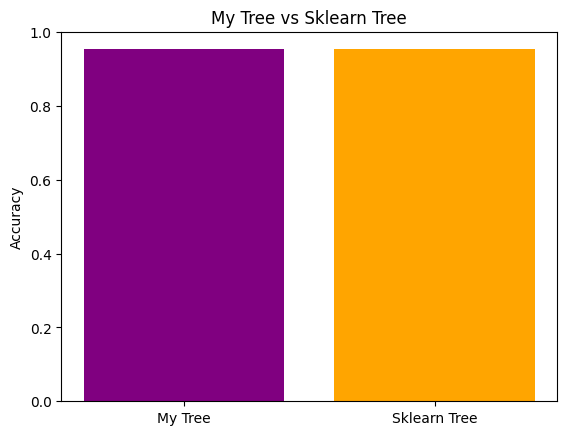

In [114]:


print(abs(sklearnaccuracy-my_acc))
print(abs(sklearnaccuracy-my_acc)/(sklearnaccuracy*100))
print("Equal" if abs(sklearnaccuracy-my_acc) == 0 else "Not equal")
import matplotlib.pyplot as plt

plt.bar(["My Tree", "Sklearn Tree"], [my_acc, sklearnaccuracy], color=["purple", "orange"])
plt.ylabel("Accuracy")
plt.title("My Tree vs Sklearn Tree")
plt.show()